In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,TensorDataset
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [6]:
from tqdm.notebook import tqdm

In [7]:
project_name = 'project-plant-identification'

In [9]:
data ='..\\dataset\\'
os.listdir(data)

['Flavia', 'New Plant-Dataset']

In [10]:
os.listdir(data+'New Plant-Dataset')

['orig', 'train', 'valid']

In [11]:
os.listdir(data+'New Plant-Dataset\\train')

['Augmented Arjun Leaf',
 'Augmented Curry Leaf',
 'Augmented Marsh Pennywort Leaf',
 'Augmented Mint Leaf',
 'Augmented Neem Leaf',
 'Augmented Rubble Leaf']

In [12]:
unique_plants: list[str] = []
cl = os.listdir(data+'New Plant-Dataset\\train')
for i in cl:
    x = i.split('_')
    if x[0] not in unique_plants:
        unique_plants.append(x[0])
print("Number of Unique Plants: ",len(unique_plants))
print("Unique Plants: ",unique_plants)

Number of Unique Plants:  6
Unique Plants:  ['Augmented Arjun Leaf', 'Augmented Curry Leaf', 'Augmented Marsh Pennywort Leaf', 'Augmented Mint Leaf', 'Augmented Neem Leaf', 'Augmented Rubble Leaf']


In [13]:

# Define desired height and width
desired_height = 128
desired_width = 128

# Define transformation
transform = transforms.Compose([
    transforms.Resize((desired_height, desired_width)),
    transforms.ToTensor()
])

In [14]:
dataset = ImageFolder(data+'New Plant-Dataset\\train',transform=transform)
test_ds = ImageFolder(data+'New Plant-Dataset\\orig',transform=transform)

In [15]:
print("Number of training images: ",len(dataset))
print("Number of testing images: ",len(test_ds))

Number of training images:  9660
Number of testing images:  1380


In [16]:
num_classes = dataset.classes
print("Number of classes: ",len(num_classes))
print(num_classes)

Number of classes:  6
['Augmented Arjun Leaf', 'Augmented Curry Leaf', 'Augmented Marsh Pennywort Leaf', 'Augmented Mint Leaf', 'Augmented Neem Leaf', 'Augmented Rubble Leaf']


In [17]:
image, label  = dataset[0]
print("Image shape:",image.shape)
print("Image Label: ",label)
print("Image Label: ",dataset.classes[label])
print(image)

Image shape: torch.Size([3, 128, 128])
Image Label:  0
Image Label:  Augmented Arjun Leaf
tensor([[[0.9098, 0.9020, 0.9098,  ..., 0.9961, 0.9961, 0.9961],
         [0.9059, 0.9059, 0.9098,  ..., 0.9961, 0.9961, 0.9961],
         [0.8941, 0.8980, 0.9020,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.8314, 0.8392, 0.8353,  ..., 0.9765, 0.9765, 0.9725],
         [0.8314, 0.8392, 0.8353,  ..., 0.9725, 0.9804, 0.9765],
         [0.8353, 0.8353, 0.8314,  ..., 0.9725, 0.9725, 0.9725]],

        [[0.8980, 0.8902, 0.8980,  ..., 1.0000, 1.0000, 1.0000],
         [0.8941, 0.8941, 0.8980,  ..., 1.0000, 1.0000, 1.0000],
         [0.8824, 0.8863, 0.8902,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8196, 0.8275, 0.8235,  ..., 0.9647, 0.9647, 0.9608],
         [0.8196, 0.8275, 0.8235,  ..., 0.9608, 0.9686, 0.9647],
         [0.8235, 0.8235, 0.8196,  ..., 0.9608, 0.9608, 0.9608]],

        [[0.8706, 0.8627, 0.8706,  ..., 0.9765, 0.9765, 0.9765],
         [0.8667, 0.8667, 0.8706,

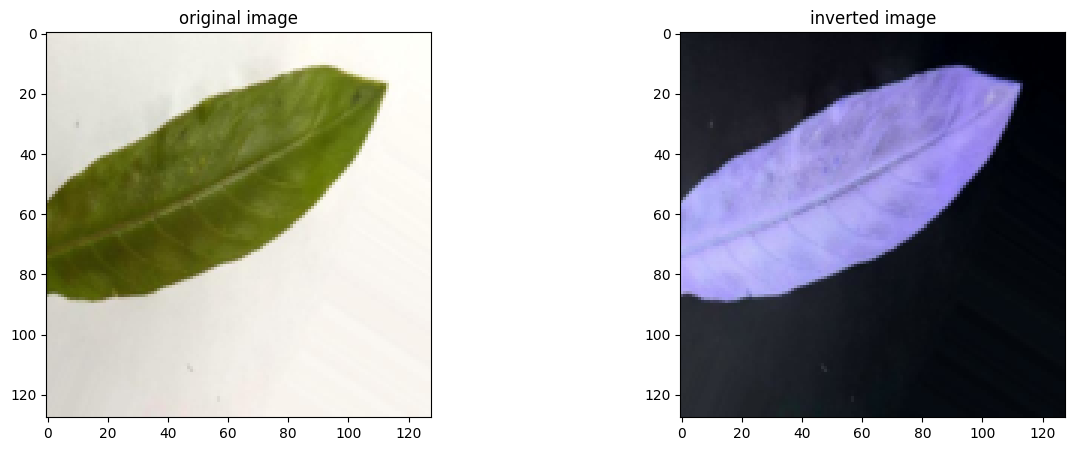

In [18]:
image, label  = dataset[0]
fig,(ax1,ax2) = plt.subplots(figsize=(15,5),nrows=1,ncols=2)
ax1.imshow(image.permute(1,2,0))
ax1.set_title("original image")
ax2.imshow(1-image.permute(1,2,0))
ax2.set_title("inverted image")
plt.show()

In [19]:
random_seed = 42
torch.manual_seed(random_seed)

In [20]:
validation_split = 0.3
val_size = int(len(dataset) * validation_split)
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])

In [21]:
batch_size = 64

train_loader = DataLoader(train_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)
test_loader = DataLoader(test_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)

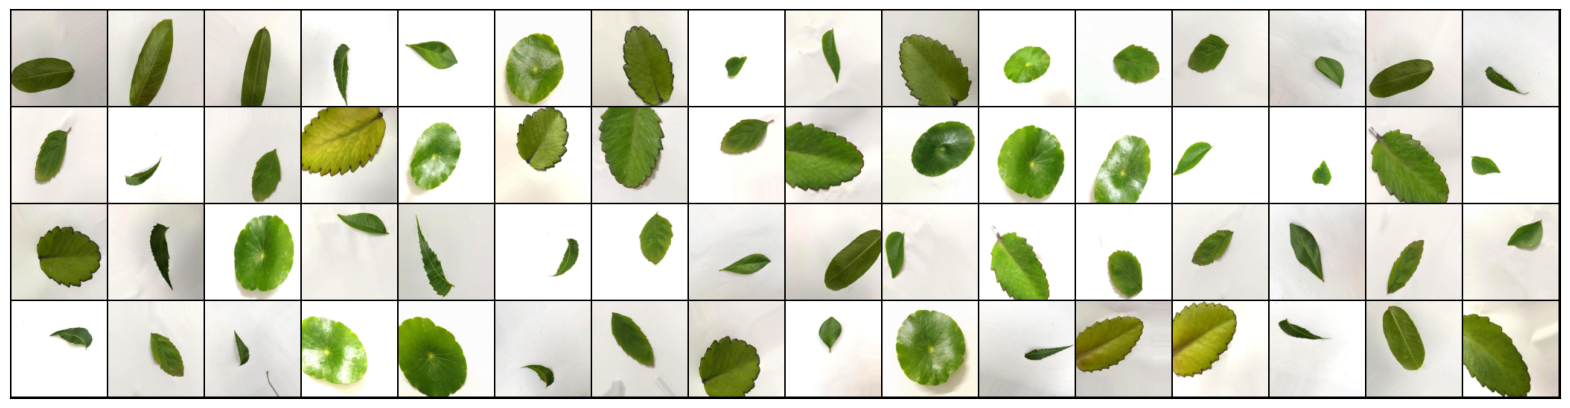

In [22]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [23]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    
  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss,'val_acc':acc}

  def validation_epoch_end(self,outputs):
    batch_loss = [out['val_loss'] for out in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [out['val_acc'] for out in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self,epoch,result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [24]:
class Herbal_Identification_Model(ImageClassificationBase):
  
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 64*64*64

        nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 128*32*32

        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 256*16*16
        
        nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 512*8*8
        
        nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(512,1024,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 1024*4*4
        nn.AdaptiveAvgPool2d(1),
        
        nn.Flatten(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,38)
        )
    
  def forward(self,xb):
    out = self.network(xb)
    return out

In [25]:
class Herbal_Identification_Model1(ImageClassificationBase):
  
  def __init__(self):
    super().__init__()
    self.network = models.vgg16(pretrained=True)
    num_ftrs = self.network.classifier[-1].in_features
    self.network.classifier[-1] = nn.Linear(num_ftrs, 38)
    
  def forward(self,xb):
    out = self.network(xb)
    return out

In [26]:
class Herbal_Identification_Model2(ImageClassificationBase):
  
  def __init__(self):
    super().__init__()
    self.network = models.resnet34(pretrained=True)
    num_ftrs = self.network.fc.in_features
    self.network.fc = nn.Linear(num_ftrs, 38)
    
  def forward(self,xb):
    out = self.network(xb)
    return out

In [27]:
@torch.no_grad()
def evaluate(model,val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [28]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [29]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [30]:
device = get_default_device()
device

device(type='cuda')

In [31]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [32]:
model = to_device(Herbal_Identification_Model2(), device)

d:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
model

Herbal_Identification_Model2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [34]:
evaluate(model,val_loader)

{'val_loss': 3.6019601821899414, 'val_acc': 0.016304347664117813}

In [35]:
history = fit(10, 0.001, model, train_loader, val_loader, opt_func = torch.optim.Adam)

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.1675, val_loss: 6.3116, val_acc: 0.4646


  0%|          | 0/106 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0724, val_loss: 0.2168, val_acc: 0.9304


  0%|          | 0/106 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0441, val_loss: 0.1289, val_acc: 0.9662


  0%|          | 0/106 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0109, val_loss: 0.0030, val_acc: 0.9990


  0%|          | 0/106 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0227, val_loss: 0.0167, val_acc: 0.9946


  0%|          | 0/106 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.0140, val_loss: 0.0042, val_acc: 0.9990


  0%|          | 0/106 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.0108, val_loss: 0.0016, val_acc: 0.9997


  0%|          | 0/106 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.0006, val_loss: 0.0013, val_acc: 0.9997


  0%|          | 0/106 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.0080, val_loss: 0.2410, val_acc: 0.9511


  0%|          | 0/106 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0355, val_loss: 0.0709, val_acc: 0.9776


In [36]:
history += fit(5, 0.001, model, train_loader, val_loader, opt_func = torch.optim.Adam)

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.0401, val_loss: 0.0202, val_acc: 0.9935


  0%|          | 0/106 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0376, val_loss: 0.2233, val_acc: 0.9404


  0%|          | 0/106 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0181, val_loss: 0.0583, val_acc: 0.9813


  0%|          | 0/106 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0191, val_loss: 0.0050, val_acc: 0.9990


  0%|          | 0/106 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0058, val_loss: 0.1931, val_acc: 0.9387


In [37]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [38]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

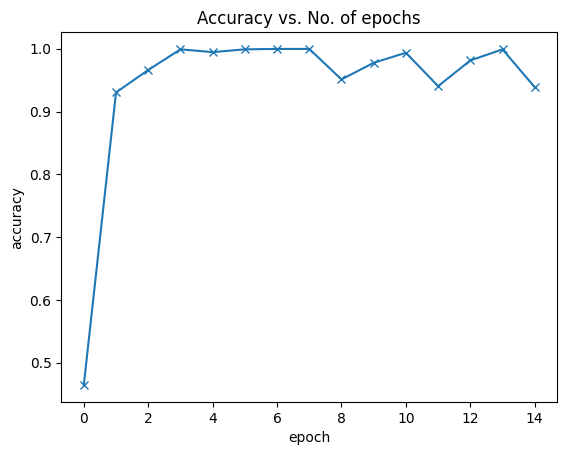

In [39]:
plot_accuracies(history)

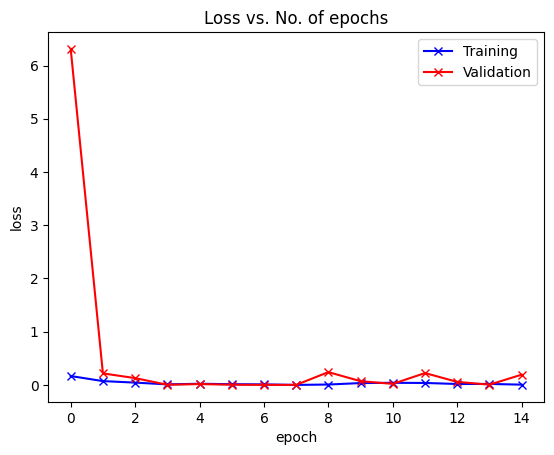

In [40]:
plot_losses(history)

In [41]:
evaluate(model,val_loader)

{'val_loss': 0.19328905642032623, 'val_acc': 0.9386699795722961}

In [42]:
x = evaluate(model,test_loader)
x

{'val_loss': 3.698692798614502, 'val_acc': 0.6903409361839294}

In [43]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    i = preds[0].item()
    print(i, type(i))
    return dataset.classes[i]

0 <class 'int'>
Label: Augmented Arjun Leaf , Predicted: Augmented Arjun Leaf


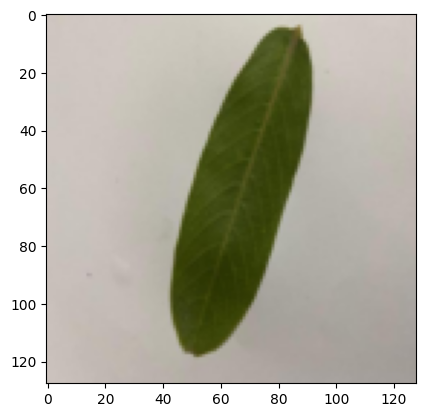

In [44]:
img, label = test_ds[25]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

5 <class 'int'>
Label: Augmented Neem Leaf , Predicted: Augmented Rubble Leaf


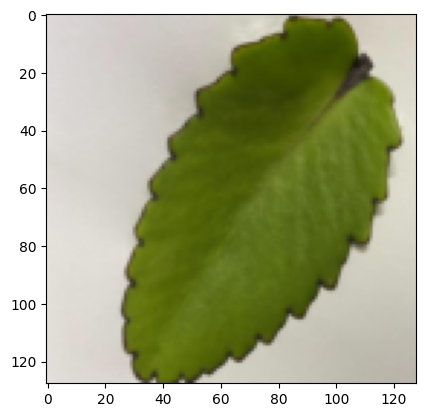

In [45]:
img, label = test_ds[978]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

1 <class 'int'>
Label: Augmented Curry Leaf , Predicted: Augmented Curry Leaf


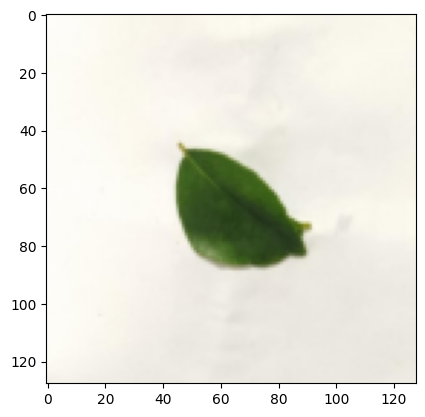

In [46]:
img, label = test_ds[258]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [47]:
print(len(test_ds))

1380


In [48]:
for i in range(len(test_ds)):
    path, target = test_ds.samples[i]
    print("Sample {}: Path: {}, Target: {}".format(i, path, target))

Sample 0: Path: ..\dataset\New Plant-Dataset\orig\Arjun Leaf\Arjun Leaf (1).JPG, Target: 0
Sample 1: Path: ..\dataset\New Plant-Dataset\orig\Arjun Leaf\Arjun Leaf (10).JPG, Target: 0
Sample 2: Path: ..\dataset\New Plant-Dataset\orig\Arjun Leaf\Arjun Leaf (100).JPG, Target: 0
Sample 3: Path: ..\dataset\New Plant-Dataset\orig\Arjun Leaf\Arjun Leaf (101).JPG, Target: 0
Sample 4: Path: ..\dataset\New Plant-Dataset\orig\Arjun Leaf\Arjun Leaf (102).JPG, Target: 0
Sample 5: Path: ..\dataset\New Plant-Dataset\orig\Arjun Leaf\Arjun Leaf (103).JPG, Target: 0
Sample 6: Path: ..\dataset\New Plant-Dataset\orig\Arjun Leaf\Arjun Leaf (104).JPG, Target: 0
Sample 7: Path: ..\dataset\New Plant-Dataset\orig\Arjun Leaf\Arjun Leaf (105).JPG, Target: 0
Sample 8: Path: ..\dataset\New Plant-Dataset\orig\Arjun Leaf\Arjun Leaf (106).JPG, Target: 0
Sample 9: Path: ..\dataset\New Plant-Dataset\orig\Arjun Leaf\Arjun Leaf (107).JPG, Target: 0
Sample 10: Path: ..\dataset\New Plant-Dataset\orig\Arjun Leaf\Arjun Leaf 

In [49]:
torch.save(model.state_dict(), '../Models/herbal-identification-resnet34.pth')

In [50]:
import jovian

<IPython.core.display.Javascript object>

In [51]:
x = [x]

# Check the content and structure of x
print(x)

# Verify the data type of x[0]
print(type(x[0]))

# Assuming x[0] is a dictionary, access the keys 'val_acc' and 'val_loss'
if isinstance(x[0], dict):
    test_acc = x[0].get('val_acc')
    test_loss = x[0].get('val_loss')
    print("Test Accuracy:", test_acc)
    print("Test Loss:", test_loss)
else:
    print("x[0] is not a dictionary as expected.")


[{'val_loss': 3.698692798614502, 'val_acc': 0.6903409361839294}]
<class 'dict'>
Test Accuracy: 0.6903409361839294
Test Loss: 3.698692798614502


In [52]:
if isinstance(x[0], dict):
    test_acc = x[0].get('val_acc')
    test_loss = x[0].get('val_loss')
    print("Test Accuracy:", test_acc)
    print("Test Loss:", test_loss)
elif isinstance(x[0], str):
    print("Evaluation result is a string:", x[0])
    # Handle the string result accordingly
else:
    print("Unexpected type for x[0]:", type(x[0]))

Test Accuracy: 0.6903409361839294
Test Loss: 3.698692798614502


In [53]:
opt = "Adam"
jovian.reset()
jovian.log_hyperparams(arch=arch, 
                       lrs=lrs, 
                       epochs=epochs,
                       optimizer=opt)


NameError: name 'arch' is not defined

In [ ]:
jovian.log_metrics(test_loss=test_loss, test_acc=test_acc)

NameError: name 'evaluation_results' is not defined

In [ ]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Error: Failed to read the Jupyter notebook. Please re-run this cell to try again. If the issue persists, provide the "filename" argument to "jovian.commit" e.g. "jovian.commit(filename='my-notebook.ipynb')"
